In [11]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

from sample_generators import CustomArgumentParser, TimeSeries
from sample_generation_tools import get_psd, get_waveforms_as_dataframe, apply_psd

## Read in the raw strain data

In [3]:
# -------------------------------------------------------------------------
# Read in the real strain data from the LIGO website
# -------------------------------------------------------------------------

event = 'GW170104'
data_path = '../data/'

# Names of the files containing the real strains, i.e. detector recordings
real_strain_file = {'H1': '{}_H1_STRAIN_4096.h5'.format(event),
                    'L1': '{}_L1_STRAIN_4096.h5'.format(event)}

# Read the HDF files into numpy arrays and store them in a dict
real_strains = dict()
for ifo in ['H1', 'L1']:

    # Make the full path for the strain file
    strain_path = os.path.join(data_path, 'strain', real_strain_file[ifo])

    # Read the HDF file into a numpy array
    with h5py.File(strain_path, 'r') as file:
        real_strains[ifo] = np.array(file['strain/Strain'])

## Calculate the Power Spectral Densities

In [4]:
# -------------------------------------------------------------------------
# Pre-calculate the Power Spectral Density from the real strain data
# -------------------------------------------------------------------------

psds = dict()
psds['H1'] = get_psd(real_strains['H1'])
psds['L1'] = get_psd(real_strains['L1'])

## Load Pre-Computed Waveforms

In [5]:
# -------------------------------------------------------------------------
# Load the pre-calculated waveforms from an HDF file into a DataFrame
# -------------------------------------------------------------------------

waveforms_file = 'waveforms_3s_0700_1200.h5'
waveforms_path = os.path.join(data_path, 'waveforms', waveforms_file)
waveforms = get_waveforms_as_dataframe(waveforms_path)

## Create a sample timeseries

In [30]:
np.random.seed(423)
sample = TimeSeries(sample_length=12,
                    sampling_rate=4096,
                    max_n_injections=2,
                    loudness=1.0,
                    noise_type='real',
                    pad=3.0,
                    waveforms=waveforms,
                    psds=psds,
                    real_strains=real_strains,
                    max_delta_t=0.01,
                    event_position=2048.6)

0.005856132734092202
[{'H1': 6.8112867777283644e-07, 'L1': 9.3117745633672765e-06}, {'H1': 1.5292452294588741e-06, 'L1': 7.0789704098605288e-06}]


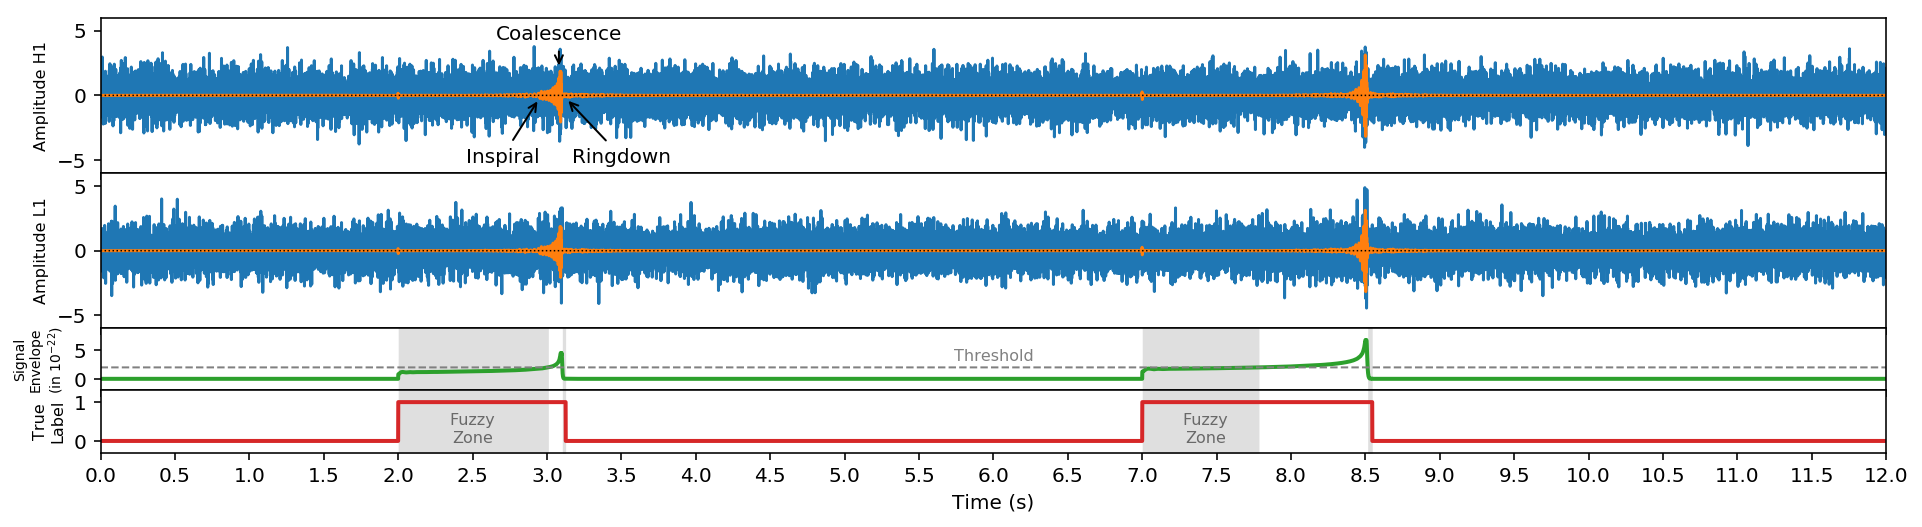

In [63]:
timeseries_H1 = sample.get_timeseries()[0, :, 0]
timeseries_L1 = sample.get_timeseries()[0, :, 1]
signals_H1 = sample.signals['H1']
signals_L1 = sample.signals['L1']
labels = sample.get_label()
chirpmasses = sample.get_chirpmass()
distances = sample.get_distance()
snrs = sample.get_snr()

print(sample.delta_t)
print(snrs)

grid = np.linspace(0, 12, 12*2048)
fig, axes = plt.subplots(nrows=4, ncols=1, sharex='col',
                         gridspec_kw={'height_ratios': [5, 5, 2, 2]}, 
                         figsize=(16, 4))

axes[0].plot(grid, timeseries_H1, color='C0')
axes[0].plot(grid, signals_H1, color='C1')
axes[0].plot(grid, [0 for _ in grid], color='Black', lw=0.75, ls=':')
axes[0].set_ylim(-6, 6)
axes[0].set_ylabel('Amplitude H1', fontsize=8)
axes[0].annotate('Coalescence', 
                 xy=(3.08, 2), xycoords='data',
                 xytext=(3.08, 4.75), textcoords='data', ha='center', va='center',
                 arrowprops=dict(arrowstyle="->"))
axes[0].annotate('Inspiral', 
                 xy=(2.95, -0.2), xycoords='data',
                 xytext=(2.7, -4.75), textcoords='data', ha='center', va='center',
                 arrowprops=dict(arrowstyle="->"))
axes[0].annotate('Ringdown', 
                 xy=(3.125, -0.2), xycoords='data',
                 xytext=(3.5, -4.75), textcoords='data', ha='center', va='center',
                 arrowprops=dict(arrowstyle="->"))


axes[1].plot(grid, timeseries_L1, color='C0')
axes[1].plot(grid, signals_H1, color='C1')
axes[1].set_ylim(-6, 6)
axes[1].plot(grid, [0 for _ in grid], color='Black', lw=0.75, ls=':')
axes[1].set_ylabel('Amplitude L1', fontsize=8)

# Calculate and plot the fuzzy-zones
THRESHOLD = 0.2e-21
fuzzy_zones = -1 * np.ones(len(labels))
for j in range(len(labels)):
    if 0 < labels[j] <= THRESHOLD:
        fuzzy_zones[j] = 1
axes[2].fill_between(grid, -10, 10*fuzzy_zones, color='Gray', alpha=0.25, lw=0)

axes[2].plot(grid, (10**22)*labels, color='C2', lw=2)
axes[2].plot(grid, [(10**22)*THRESHOLD for _ in grid], color='Gray', lw=1, ls='--', )
axes[2].set_ylim(-0.3*np.max((10**22)*labels), 1.3*np.max((10**22)*labels))
axes[2].set_ylabel('Signal\nEnvelope\n'+r'(in $10^{-22}$)',  fontsize=7)
axes[2].text(6, 4, 'Threshold', color='Gray', ha='center', va='center', fontsize=8)

axes[3].plot(grid, np.ceil(labels), color='C3', lw=2)
axes[3].fill_between(grid, -2, 2*fuzzy_zones, color='Gray', alpha=0.25, lw=0)
axes[3].set_ylim(-0.3, 1.3)
axes[3].set_ylabel('True\nLabel', fontsize=8)
axes[3].text(2.5, 0.3, 'Fuzzy\nZone', color='DimGray', ha='center', va='center', fontsize=8)
axes[3].text(7.425, 0.3, 'Fuzzy\nZone', color='DimGray', ha='center', va='center', fontsize=8)

"""
axes[3].plot(grid, chirpmasses, color='C3', lw=2)
axes[3].set_ylim(-0.3*np.max(chirpmasses), 1.3*np.max(chirpmasses))
axes[3].set_ylabel('Chirpmass')

axes[4].plot(grid, distances, color='C4', lw=2)
axes[4].set_ylim(-0.3*np.max(distances), 1.3*np.max(distances))
axes[4].set_ylabel('Distances')
"""


fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.xlim(0, 12)
plt.xticks(np.linspace(0, 12, 25))
plt.xlabel('Time (s)')
# plt.suptitle('Time Series (H1/L1), True Label and Predicted Label', y=0.95)
# plt.savefig('training_sample.pdf', bbox_inches='tight')
plt.savefig('training_sample.png', dpi=600, bbox_inches='tight')
plt.show()